Milestone 2 Phase 2 <br>
Nama : Risqi Wahyu Permana <br>
Batch : HCK 6 <br>

# Introduction

Background : Seorang pesaing X(Twitter) ingin mengetahui sentiment pengguna X(Twitter) atas perubahan nama platform pesaingnya.

Problem : Tim Data Science disuruh untuk membuat sebuah model deep learning untuk memprediksi sentiment pengguna platform X(Twitter) atas perubahan nama platform tersebut.

Pengenalan Dataset :
1. Dataset yang digunakan untuk melatih model adalah dataset yang berasal dari [Kaggle](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset).
2. Untuk data test berasal dari hasil scrapping X(Twitter).


# Scrapping Code

Scrapping menggunakan referensi dari [blog ini](https://helmisatria.com/blog/crawl-data-twitter-menggunakan-tweet-harvest)



```python
!curl -sL https://deb.nodesource.com/setup_18.x | sudo -E bash -
!sudo apt-get install -y nodejs
!npm install -g npm@9.8.1

# Crawl Data

filename = 'X_sentiment.csv' # File Name for csv file.
search_keyword = 'X twitter min_faves:100 lang:en' # input keyword with filter minimal like 100 and used english language.
limit = 1000 # limit to get data

!npx --yes tweet-harvest@latest -o "{filename}" -s "{search_keyword}" -l {limit} --token "" # on promt, we need input our X token on prompt.

import pandas as pd

# Specify the path to your CSV file
file_path = f"tweets-data/{filename}"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter=";")

# Display the DataFrame
display(df)
```



# Download Glove

In [1]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, TextVectorization, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model, load_model

from wordcloud import WordCloud, STOPWORDS
stop_words = stopwords.words('english')

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
np.random.seed(50)
tf.random.set_seed(50)

# Connect to Drive

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Loading

In [5]:
data = pd.read_csv('/content/gdrive/MyDrive/Data Science/Dataset/Tweets.csv').drop(['textID', 'selected_text'], axis=1)
data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


# Text Cleaning

Ini merupakan sebuah proses untuk menghilangkan karakter - karakter aneh pada dataset.

Tujuan dari text cleaning adalah untuk menghilangkan noise, karakter khusus, dan informasi yang tidak relevan sehingga teks dapat diolah lebih efisien dan hasil analisis menjadi lebih baik.

In [6]:
def text_proses(teks):
  # Ubah ke string
  teks = str(teks)

  # Mengubah Teks ke Lowercase
  teks = teks.lower()

  # Menghilangkan Mention
  teks = re.sub("@[A-Za-z0-9_]+", " ", teks)

  # Menghilangkan Hashtag
  teks = re.sub("#[A-Za-z0-9_]+", " ", teks)

  # Menghilangkan \n
  teks = re.sub(r"\\n", " ",teks)

  # Menghilangkan Whitespace
  teks = teks.strip()

  # Menghilangkan Link
  teks = re.sub(r"http\S+", " ", teks)
  teks = re.sub(r"www.\S+", " ", teks)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
  teks = re.sub("[^A-Za-z\s']", " ", teks)

  # Menghilangkan RT
  teks = re.sub("rt", " ",teks)

  # Melakukan Tokenisasi
  tokens = word_tokenize(teks)

  # Lemmatization verb
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]

  # Menghilangkan Stopwords
  stpwds_id = list(set(stopwords.words('english')))
  teks = ' '.join([word for word in lemmatized_tokens if word not in stpwds_id])

  return teks

In [7]:
data_process = data.copy()

In [8]:
data_process['text_processed'] = data_process['text'].apply(lambda x: text_proses(x))
data_process

,text,sentiment,text_processed
0,"I`d have responded, if I were going",neutral,respond go
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,boss bully
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,sons put release already buy
...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,wish could come see u denver husband lose job ...
27477,I`ve wondered about rake to. The client has ...,negative,wonder rake client make clear net force devs l...
27478,Yay good for both of you. Enjoy the break - y...,positive,yay good enjoy break probably need hectic week...
27479,But it was worth it ****.,positive,wo h


# Splitting Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_process.text_processed,
                                                    data_process.sentiment,
                                                    test_size=0.25,
                                                    random_state=46,
                                                    stratify=data_process.sentiment)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (20610,)
Test Size  :  (6871,)


In [10]:
# For EDA Purpose
combined_train = pd.concat([X_train, y_train], axis=1)
combined_test = pd.concat([X_test, y_test], axis=1)

In [11]:
# Convert sentiment labels to numeric form using binary encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.to_list())
y_test = label_encoder.fit_transform(y_test.to_list())

# Reshape the encoded labels to prepare for one-hot encoding
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Perform one-hot encodsing on the reshaped labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)

# EDA

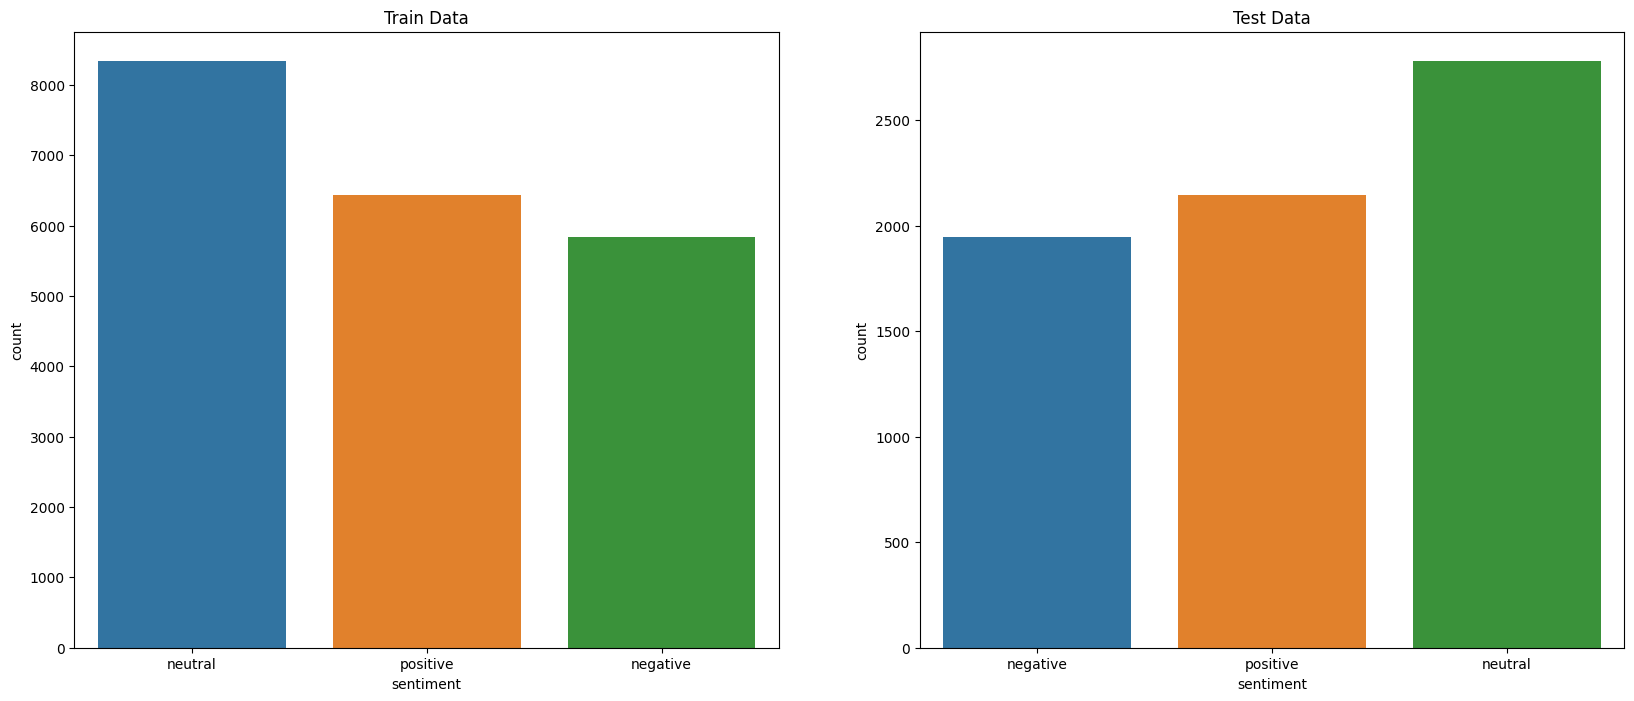

In [12]:
# Count plot of the sentiment column for both train and test data
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.countplot(x='sentiment', data=combined_train, ax=ax[0])
sns.countplot(x='sentiment', data=combined_test, ax=ax[1])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')
plt.show()

Bisa dilihat dari data train dan test, data target tidak balance namun tidak terlalu parah.

In [13]:
combined_train['temp_list'] = combined_train['text_processed'].apply(lambda x:str(x).split())
top = Counter([item for sublist in combined_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='inferno')

,Common_words,count
0,get,2394
1,go,2133
2,day,1589
3,good,1170
4,work,1134
5,like,1117
6,love,1037
7,today,858
8,time,842
9,think,803


Dapat dilihat kemunculan kata yang paling banyak muncul

In [14]:
# Find the top 20 words on each sentiment

Positive_sent = combined_train[combined_train['sentiment']=='positive']
Negative_sent = combined_train[combined_train['sentiment']=='negative']
Neutral_sent = combined_train[combined_train['sentiment']=='neutral']

#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(10))
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

#MosT common neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(10))
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

# Display all 3, temp_positive, temp_negative, temp_neutral gradients side by side
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3, subplot_titles=("Positive", "Negative", "Neutral"))

fig.add_trace(
    go.Bar(x=temp_positive['Common_words'], y=temp_positive['count'], marker=dict(color=temp_positive['count'], coloraxis="coloraxis")),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=temp_negative['Common_words'], y=temp_negative['count'], marker=dict(color=temp_negative['count'], coloraxis="coloraxis")),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=temp_neutral['Common_words'], y=temp_neutral['count'], marker=dict(color=temp_neutral['count'], coloraxis="coloraxis")),
    row=1, col=3
)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Top 10 Common Words in Tweets")
fig.show()

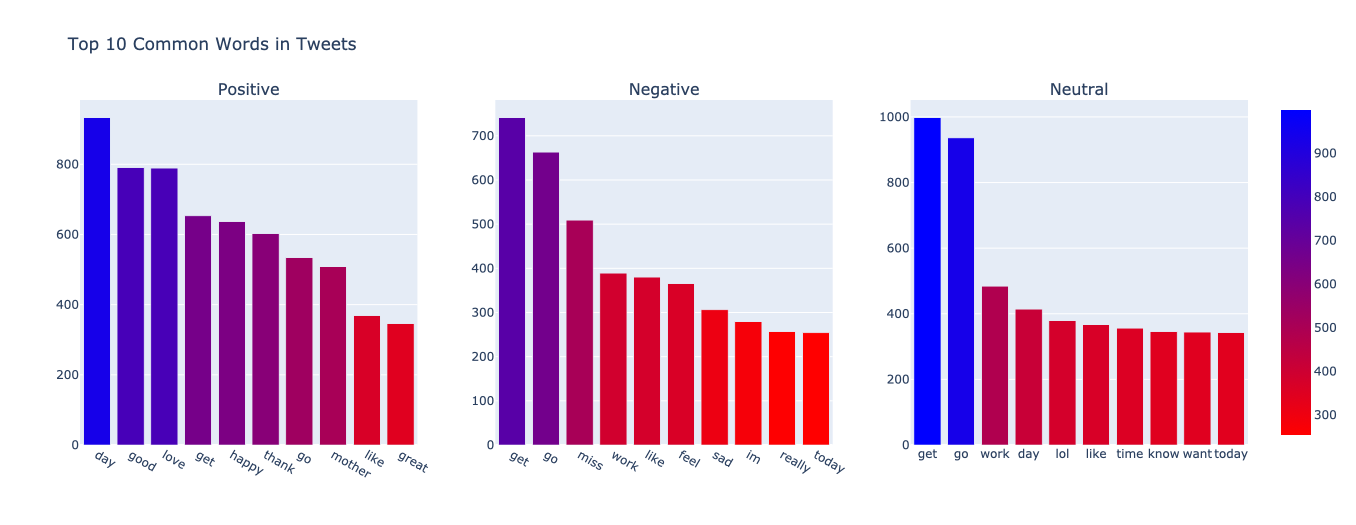

Dari grafik diatas dapat dilihat kemunculan setiap kata pada setiap kategori sentiment.

In [15]:
from wordcloud import ImageColorGenerator, WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    mask = None)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

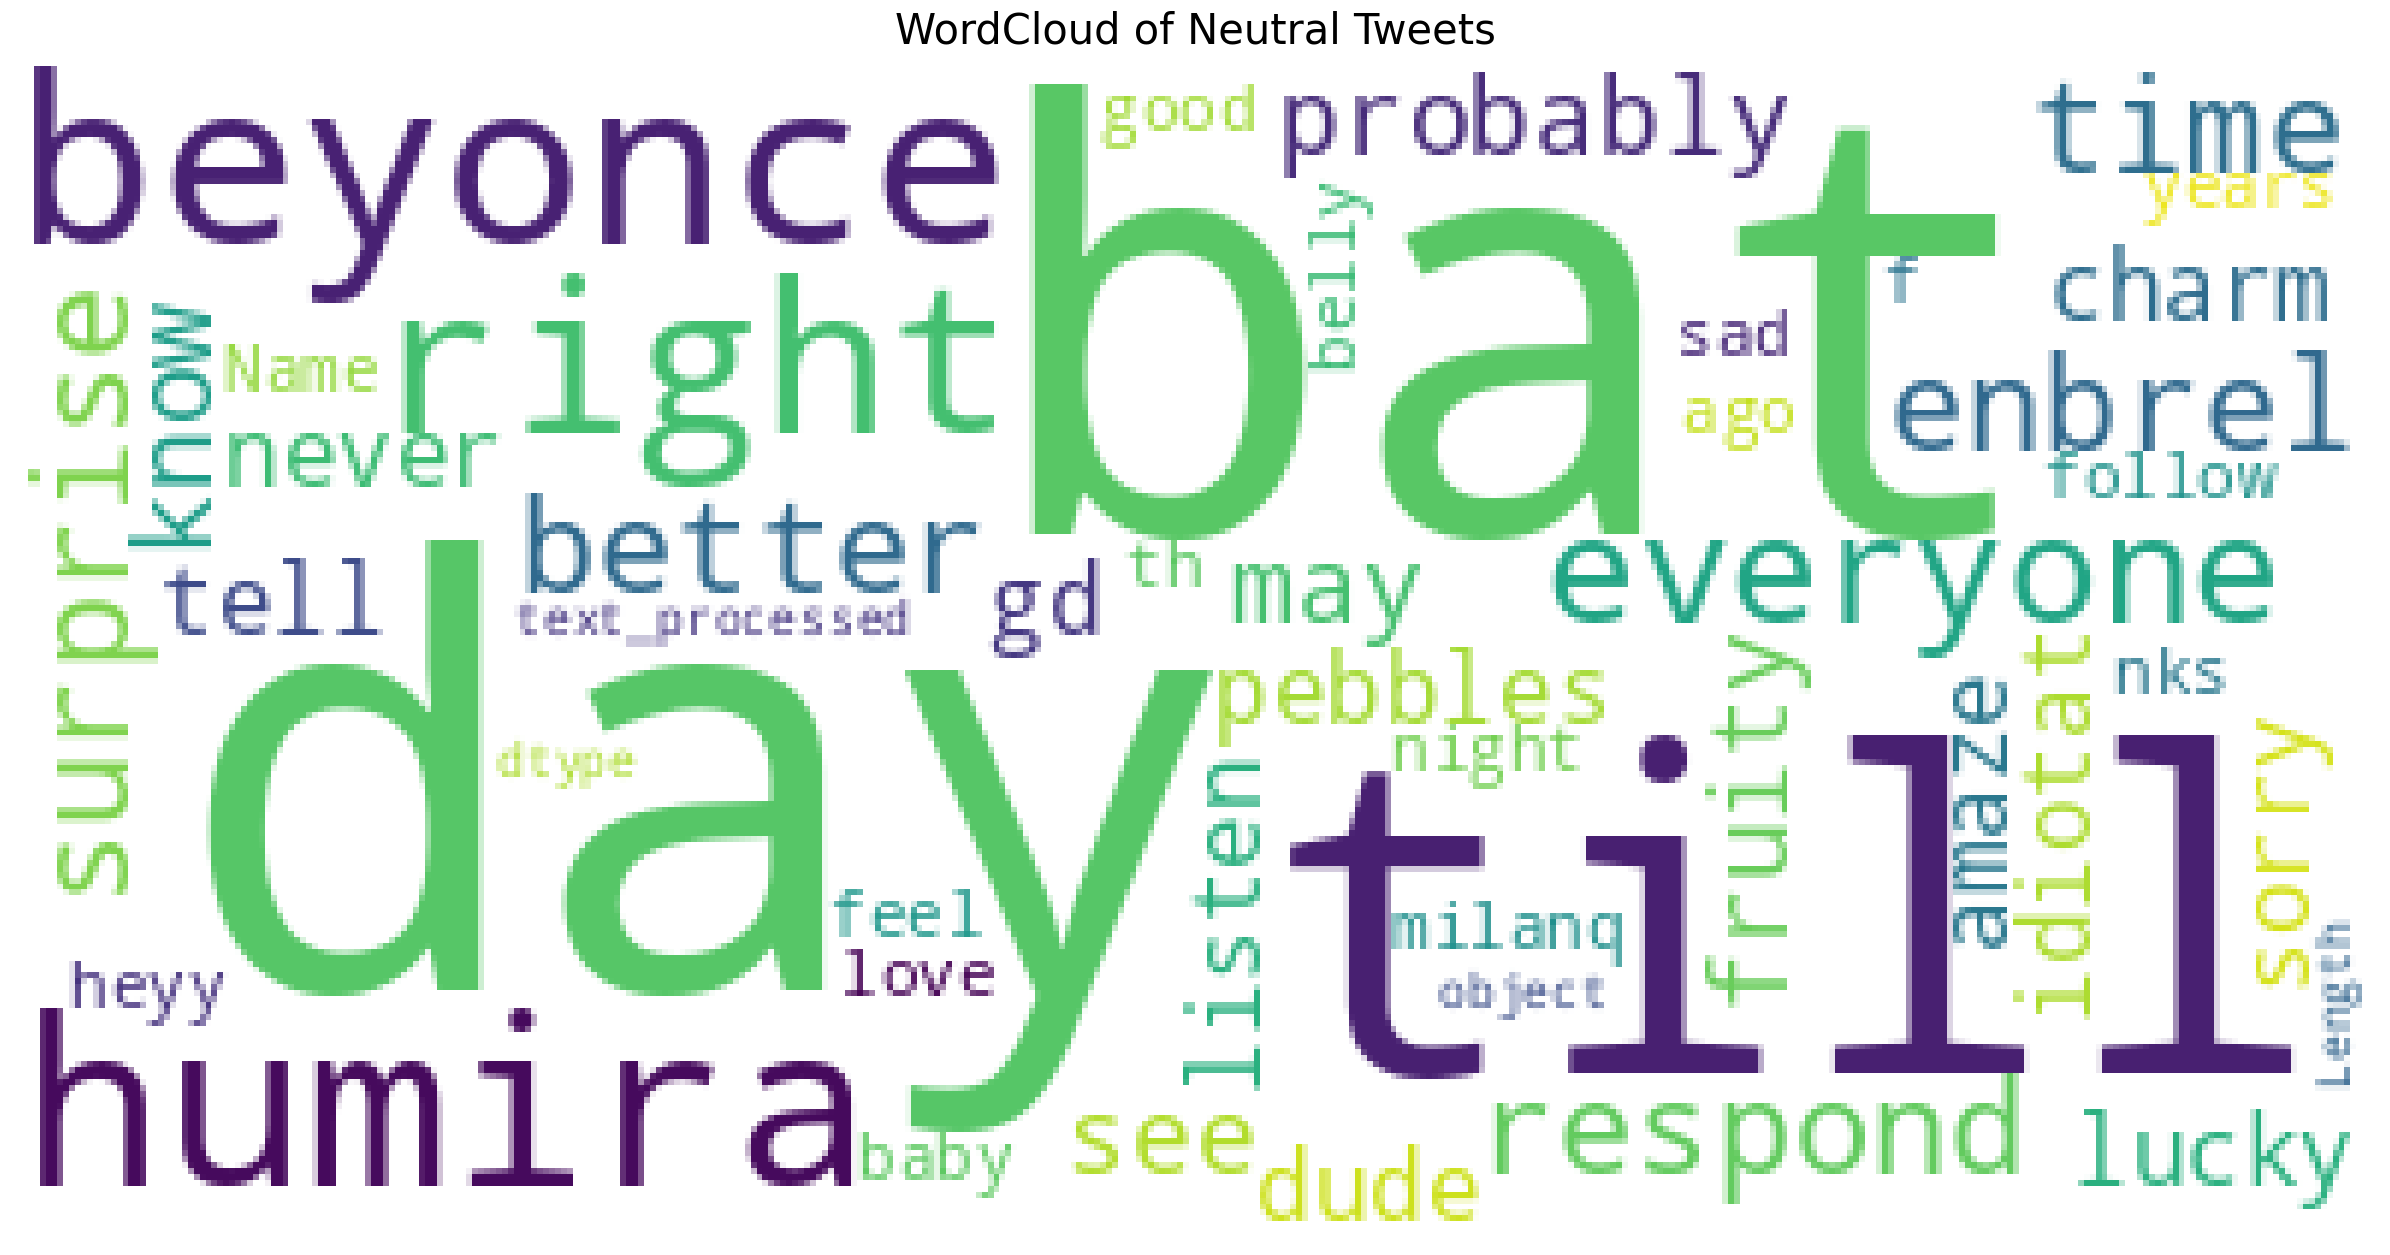

In [16]:
pos_mask = np.array('sentiment.png')
plot_wordcloud(Neutral_sent.text_processed,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

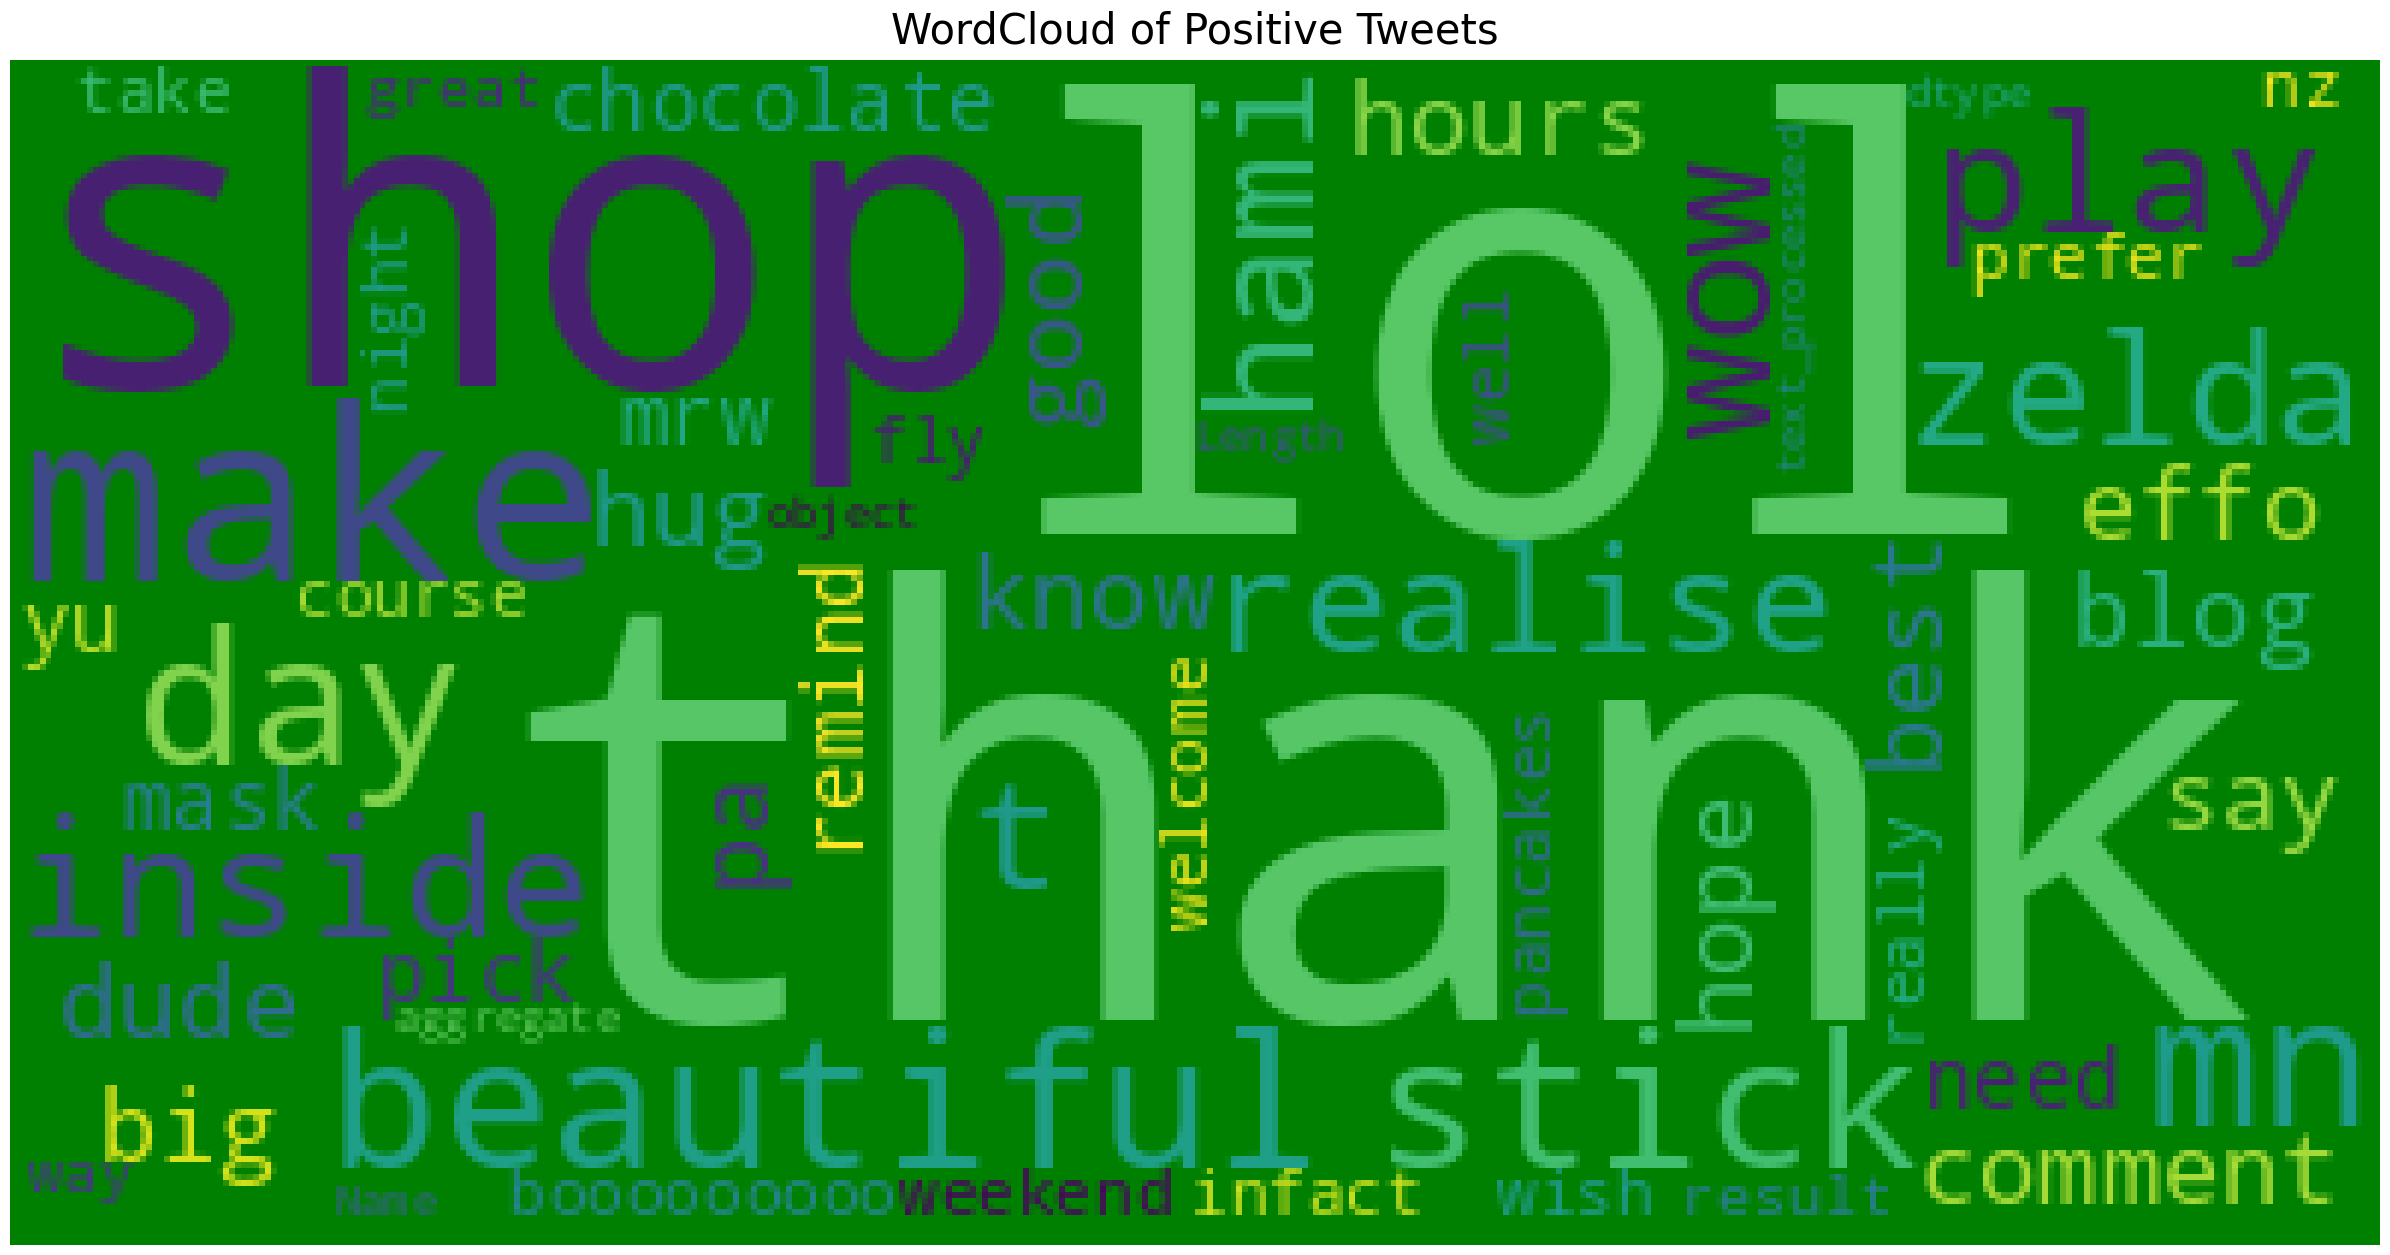

In [17]:
pos_mask = np.array('sentiment.png')
plot_wordcloud(Positive_sent.text_processed,mask=pos_mask,color='green',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

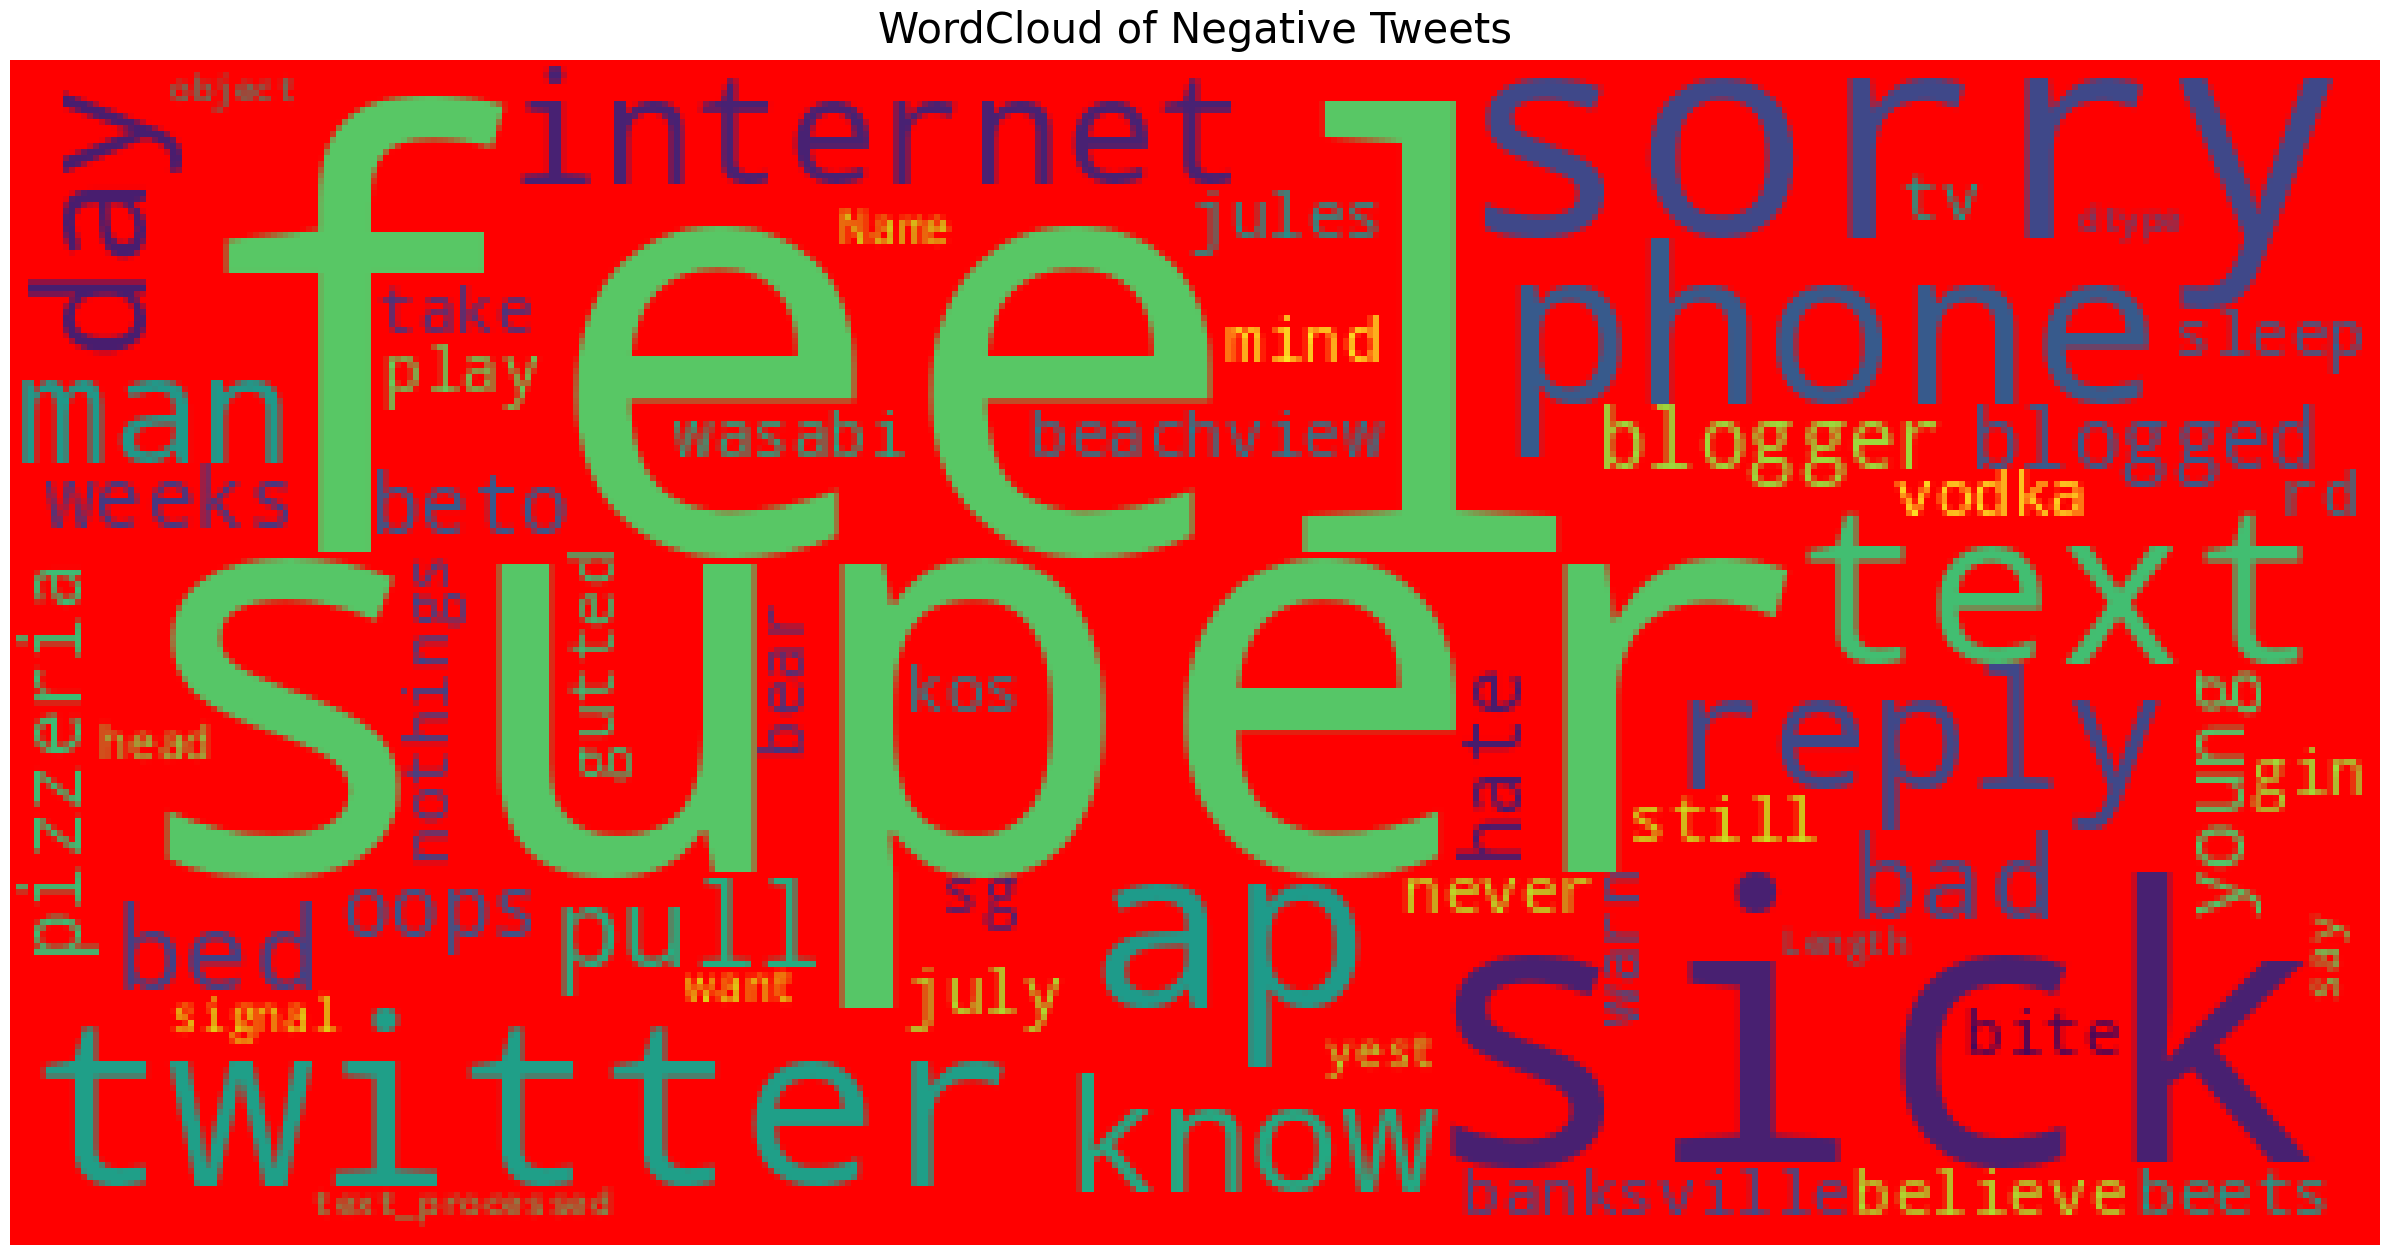

In [18]:
pos_mask = np.array('sentiment.png')
plot_wordcloud(Negative_sent.text_processed,mask=pos_mask,color='red',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")

Dari Wordcloud diatas, kita dapat melihat kata - kata yang merepresentasikan masing - masing sentiment.

# Modeling

# First time modeling

In [19]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<20610x17117 sparse matrix of type '<class 'numpy.int64'>'
	with 137814 stored elements in Compressed Sparse Row format>

In [20]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu Document

jml_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", jml_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  17117
Panjang maksimum kalimat :  25 kata


In [21]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

In [22]:
# Embedding
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

Model menggunakan sequential api

In [23]:
# Model Training dengan Menggunakan LSTM

#Input layer
model_1 = Sequential()
model_1.add(text_vectorization) #Text Vectorization Layer: Mengubah teks menjadi urutan angka.
model_1.add(embedding) #Embedding Layer: Mengkonversi urutan angka menjadi vektor embedding.
#Hidden Layer
model_1.add(SpatialDropout1D(0.2)) #Dropout layer untuk mengurangi overfitting dengan mengatur beberapa unit ke nol secara acak.
model_1.add(Conv1D(64, 5, activation='relu')) #Layer konvolusi satu dimensi dengan 64 filter dan kernel_size 5, menggunakan fungsi aktivasi ReLU.
model_1.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))) #LSTM layer dengan 64 unit yang berjalan maju (forward) dan mundur (backward), serta dropout dan recurrent dropout untuk mengurangi overfitting.
model_1.add(Dense(512, activation='relu')) #Fully connected layer dengan 512 unit dan fungsi aktivasi ReLU.
model_1.add(Dropout(0.5)) #Dropout layer dengan tingkat dropout 0.5 untuk mengurangi overfitting.
model_1.add(Dense(512, activation='relu')) #Fully connected layer lagi dengan 512 unit dan fungsi aktivasi ReLU.
#Output Layer
model_1.add(Dense(3,activation='softmax'))

model_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

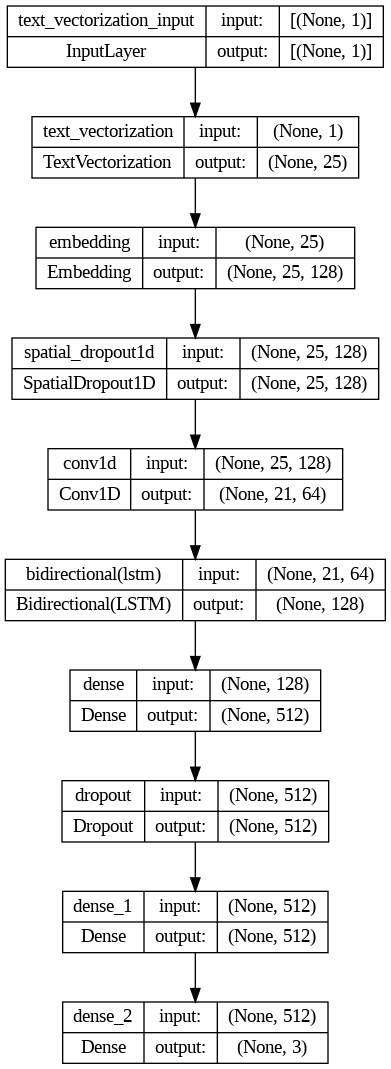

In [24]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

In [25]:
model_lstm_hist_1 = model_1.fit(X_train,
                                y_train,
                                batch_size = 1024,
                                epochs=50,
                                validation_data=(X_test, y_test))

Epoch 1/50
21/21 [==============================] - 18s 387ms/step - loss: 1.0842 - accuracy: 0.3999 - val_loss: 1.0638 - val_accuracy: 0.4448
Epoch 2/50
21/21 [==============================] - 7s 349ms/step - loss: 0.9566 - accuracy: 0.5338 - val_loss: 0.8064 - val_accuracy: 0.6437
Epoch 3/50
21/21 [==============================] - 7s 348ms/step - loss: 0.6589 - accuracy: 0.7312 - val_loss: 0.7607 - val_accuracy: 0.6727
Epoch 4/50
21/21 [==============================] - 6s 267ms/step - loss: 0.4907 - accuracy: 0.8145 - val_loss: 0.8029 - val_accuracy: 0.6811
Epoch 5/50
21/21 [==============================] - 6s 270ms/step - loss: 0.3765 - accuracy: 0.8617 - val_loss: 0.9148 - val_accuracy: 0.6807
Epoch 6/50
21/21 [==============================] - 5s 233ms/step - loss: 0.3037 - accuracy: 0.8892 - val_loss: 1.0264 - val_accuracy: 0.6670
Epoch 7/50
21/21 [==============================] - 6s 271ms/step - loss: 0.2483 - accuracy: 0.9118 - val_loss: 1.1406 - val_accuracy: 0.6523
Epoch

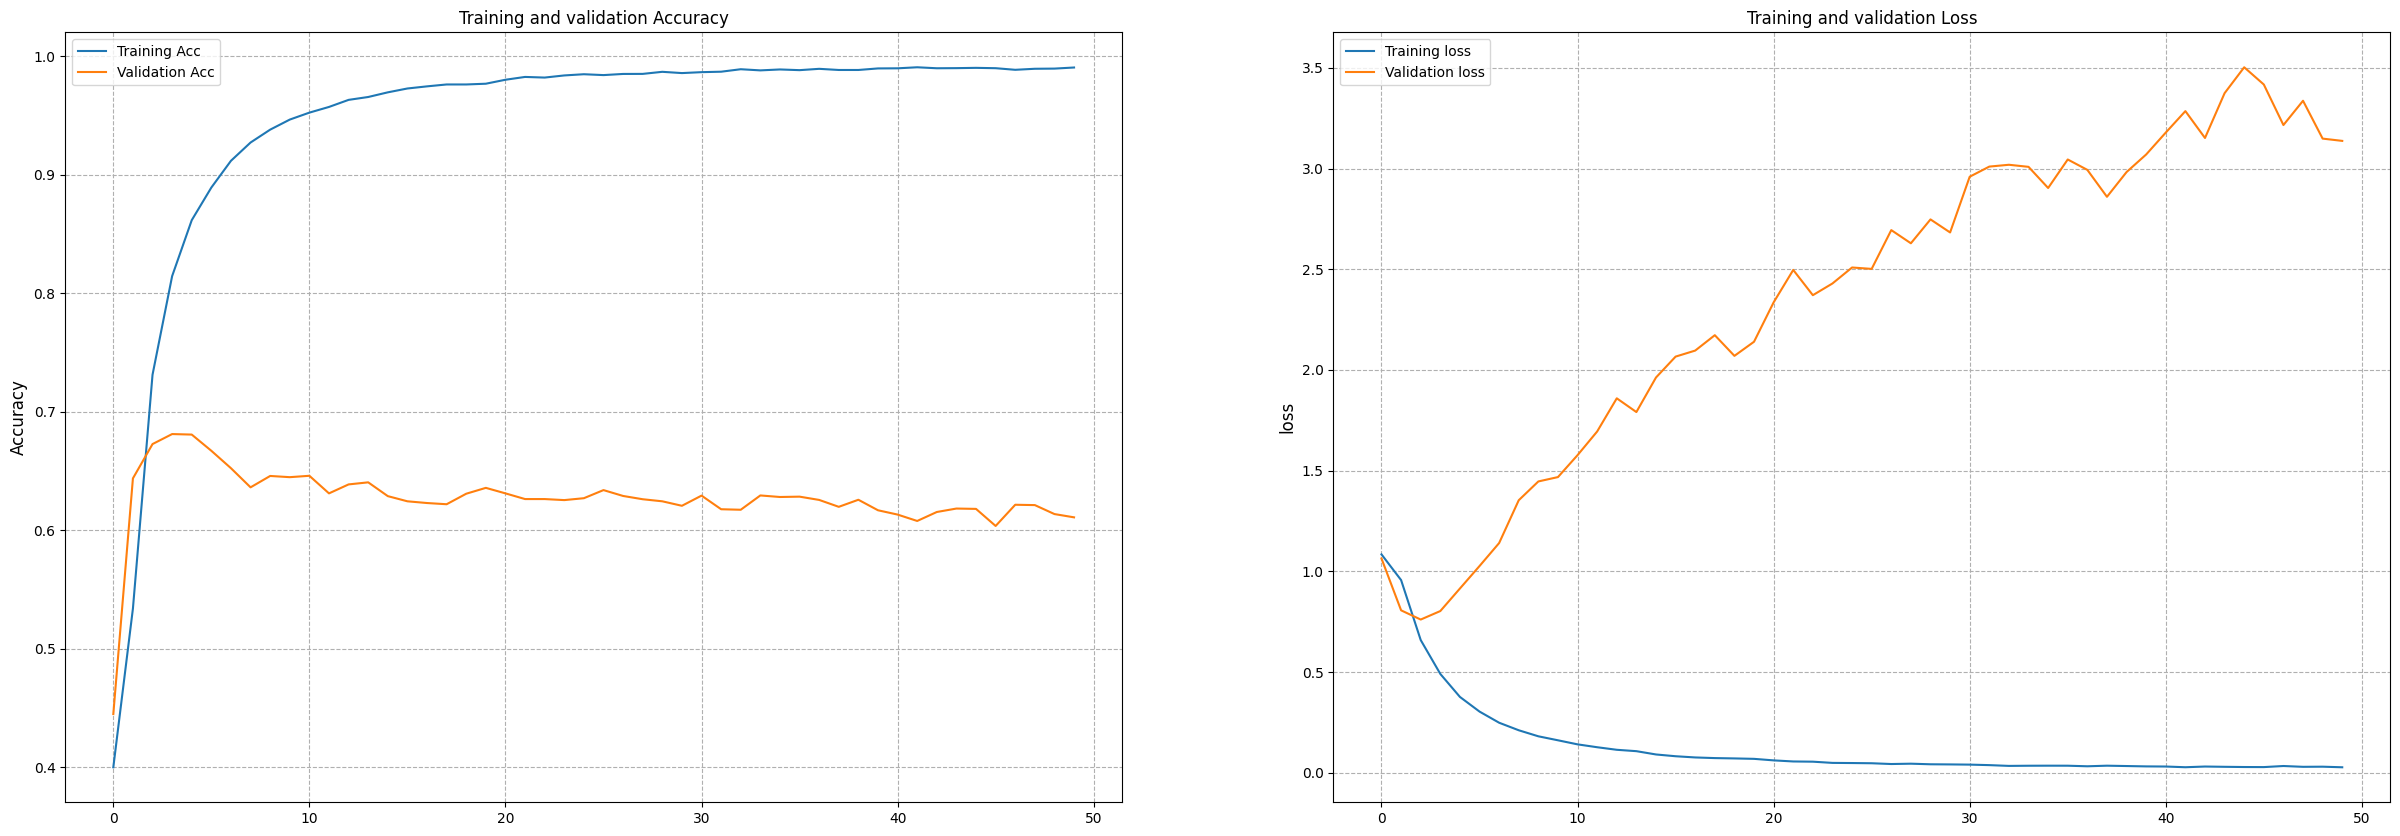

In [26]:
fig,ax= plt.subplots(1,2 , figsize=(30,10))

plt.subplot(1,2,1)
plt.title('Training and validation Accuracy', fontsize=12)
plt.plot(model_lstm_hist_1.history['accuracy'], label='Training Acc')
plt.plot(model_lstm_hist_1.history['val_accuracy'], label='Validation Acc')
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title('Training and validation Loss', fontsize=12)
plt.plot(model_lstm_hist_1.history['loss'], label='Training loss')
plt.plot(model_lstm_hist_1.history['val_loss'], label='Validation loss')
plt.ylabel('loss', fontsize=12)
plt.legend()
plt.grid(linestyle='--')
plt.show()

Berdasarkan grafik diatas bisa dilihat bahwa model mengalami overfitting

In [27]:
#print accuracy and loss on train and test
print('Train Accuracy: ', model_1.evaluate(X_train, y_train)[1])
print('Test Accuracy: ', model_1.evaluate(X_test, y_test)[1])

645/645 [==============================] - 10s 15ms/step - loss: 0.0145 - accuracy: 0.9956
Train Accuracy:  0.9956331849098206
215/215 [==============================] - 3s 15ms/step - loss: 3.1373 - accuracy: 0.6108
Test Accuracy:  0.6108281016349792


In [28]:
scores = model_1.predict(X_test, verbose = 1, batch_size = 10000)
scores[:2]

1/1 [==============================] - 1s 642ms/step


array([[1.0000000e+00, 6.8580936e-09, 1.7880905e-11],
       [4.5750585e-06, 8.0728298e-04, 9.9918813e-01]], dtype=float32)

In [29]:
binary_predictions = np.where(scores == np.max(scores, axis=1, keepdims=True), 1, 0)
binary_predictions

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [30]:
def conmat_dec(y_test, binary_predictions):
    # Convert one-hot encoded predictions to class labels
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(binary_predictions, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and axis for the confusion matrix plot
    fig, ax = plt.subplots()

    # Plot the confusion matrix as a heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Customize the plot
    ax.figure.colorbar(im, ax=ax)
    classes = ['Positive', 'Negative', 'Neutral']  # Specify the class labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           xlabel='Predicted label', ylabel='True label',
           title='Confusion Matrix')
    plt.xticks(rotation=45)

    # Add text annotations to each cell
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Display the plot
    plt.tight_layout()
    plt.show()

    report = classification_report(y_true, y_pred)

    # Print the classification report
    print("Classification Report:")
    print(report)

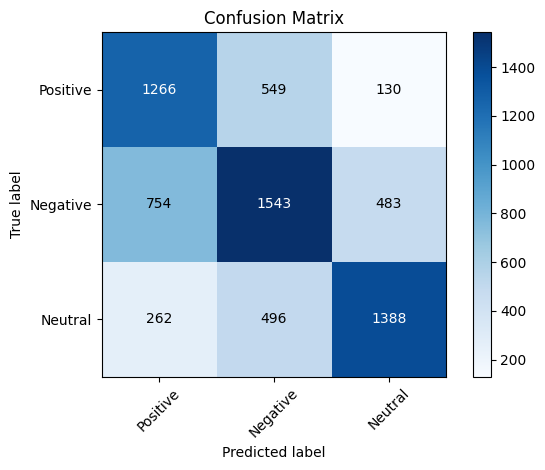

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.65      0.60      1945
           1       0.60      0.56      0.57      2780
           2       0.69      0.65      0.67      2146

    accuracy                           0.61      6871
   macro avg       0.61      0.62      0.61      6871
weighted avg       0.61      0.61      0.61      6871



In [31]:
conmat_dec(y_test, binary_predictions)

Pada confusion matrix diatas dapat dilihat masih tinggi kesalahan dalam memprediksi sentiment yang benar.

Pada Classification Report dapat dilihat nilai accuracy kurang bagus, yaitu 61%.

# Improve Model

Yang dilakukan pada Improve model:
1. Improve model menggunakan GloVe untuk proses embbeding.
2. Menggunakan functional api.
3. Menambahkan atau mengganti layer beserta parameter di dalamnya.
4. menggunakan Padding
5. Menggunakan Learning Rate pada optimizer.
6. Mengganti batch_size menjadi 2048.

Mendapatkan vocab size

In [32]:
#use tf.keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 17352


Padding

In [33]:
MAX_LENGTH = 30

X_train1 = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LENGTH)
X_test1 = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_LENGTH)

print("Training X Shape:",X_train1.shape)
print("Testing X Shape:",X_test1.shape)

Training X Shape: (20610, 30)
Testing X Shape: (6871, 30)


Setiap kalimat dalam X_train dan X_test akan dipad menjadi panjang 30 token. Jika kalimat memiliki lebih dari 30 token, maka token-token di luar 30 akan dipotong sehingga hanya token-token pertama 30 yang akan digunakan. Jika kalimat memiliki kurang dari 30 token, maka padding dengan nilai 0 akan ditambahkan di awal kalimat sehingga total panjangnya menjadi 30.

Load GloVe

In [34]:
GLOVE_EMB = 'glove.6B.300d.txt'

embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [35]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False)

In [37]:
# functional API

#Input layer
input_layer= Input(shape=(MAX_LENGTH, ),name='input_layer')
# Hidden layer
embedding_ = embedding_layer(input_layer) #Embedding Layer: Mengkonversi urutan token menjadi vektor embedding.
spatial_dropout = SpatialDropout1D(0.2)(embedding_) #SpatialDropout1D(0.2): Dropout layer untuk mengurangi overfitting dengan mengatur beberapa unit ke nol secara acak pada dimensi ruang.
bidirect = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(spatial_dropout) #Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)): LSTM layer dengan 64 unit yang berjalan maju (forward) dan mundur (backward), serta dropout dan recurrent dropout untuk mengurangi overfitting.

hidden_1 = Dense(300, activation='relu', name='hidden_1')(bidirect) #Fully connected layer dengan 300 unit dan fungsi aktivasi ReLU.
dropout_1 = x = Dropout(0.5)(hidden_1) #Dropout layer dengan tingkat dropout 0.5 untuk mengurangi overfitting.

hidden_2= Dense(200, activation='relu', name='hidden_2')(dropout_1) #Fully connected layer dengan 200 unit dan fungsi aktivasi ReLU.
dropout_2 = x = Dropout(0.5)(hidden_2) #Dropout layer dengan tingkat dropout 0.5 untuk mengurangi overfitting.

hidden_3= Dense(100, activation='relu', name='hidden_3')(dropout_2) #Fully connected layer dengan 100 unit dan fungsi aktivasi ReLU.
dropout_3 = x = Dropout(0.5)(hidden_3) #Dropout layer dengan tingkat dropout 0.5 untuk mengurangi overfitting.
# Output Layer
output_layer= Dense(3, activation='softmax', name='output_layer')(dropout_3) #Layer output dengan 3 unit (mewakili tiga kelas atau kategori sentimen) dan fungsi aktivasi softmax untuk output probabilitas kelas.

model_func= Model(input_layer,
                output_layer)

LR = 1e-3

model_func.compile(optimizer = Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = ['accuracy'])

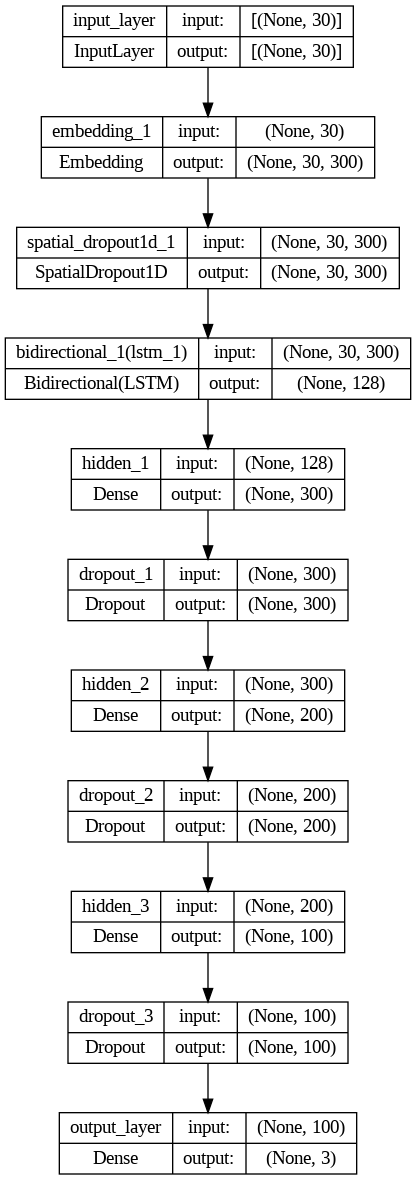

In [38]:
tf.keras.utils.plot_model(model_func, show_shapes=True)

In [39]:
history = model_func.fit(X_train1, y_train, batch_size = 2048, epochs = 50, validation_data = (X_test1, y_test))

Epoch 1/50
11/11 [==============================] - 8s 240ms/step - loss: 0.6586 - accuracy: 0.3764 - val_loss: 0.6260 - val_accuracy: 0.4161
Epoch 2/50
11/11 [==============================] - 2s 175ms/step - loss: 0.6306 - accuracy: 0.4272 - val_loss: 0.6035 - val_accuracy: 0.5145
Epoch 3/50
11/11 [==============================] - 2s 177ms/step - loss: 0.5971 - accuracy: 0.5014 - val_loss: 0.5401 - val_accuracy: 0.5612
Epoch 4/50
11/11 [==============================] - 2s 184ms/step - loss: 0.5560 - accuracy: 0.5556 - val_loss: 0.5068 - val_accuracy: 0.6162
Epoch 5/50
11/11 [==============================] - 2s 176ms/step - loss: 0.5291 - accuracy: 0.5970 - val_loss: 0.4940 - val_accuracy: 0.6388
Epoch 6/50
11/11 [==============================] - 2s 178ms/step - loss: 0.5178 - accuracy: 0.6206 - val_loss: 0.4744 - val_accuracy: 0.6632
Epoch 7/50
11/11 [==============================] - 2s 174ms/step - loss: 0.4998 - accuracy: 0.6405 - val_loss: 0.4641 - val_accuracy: 0.6763
Epoch 

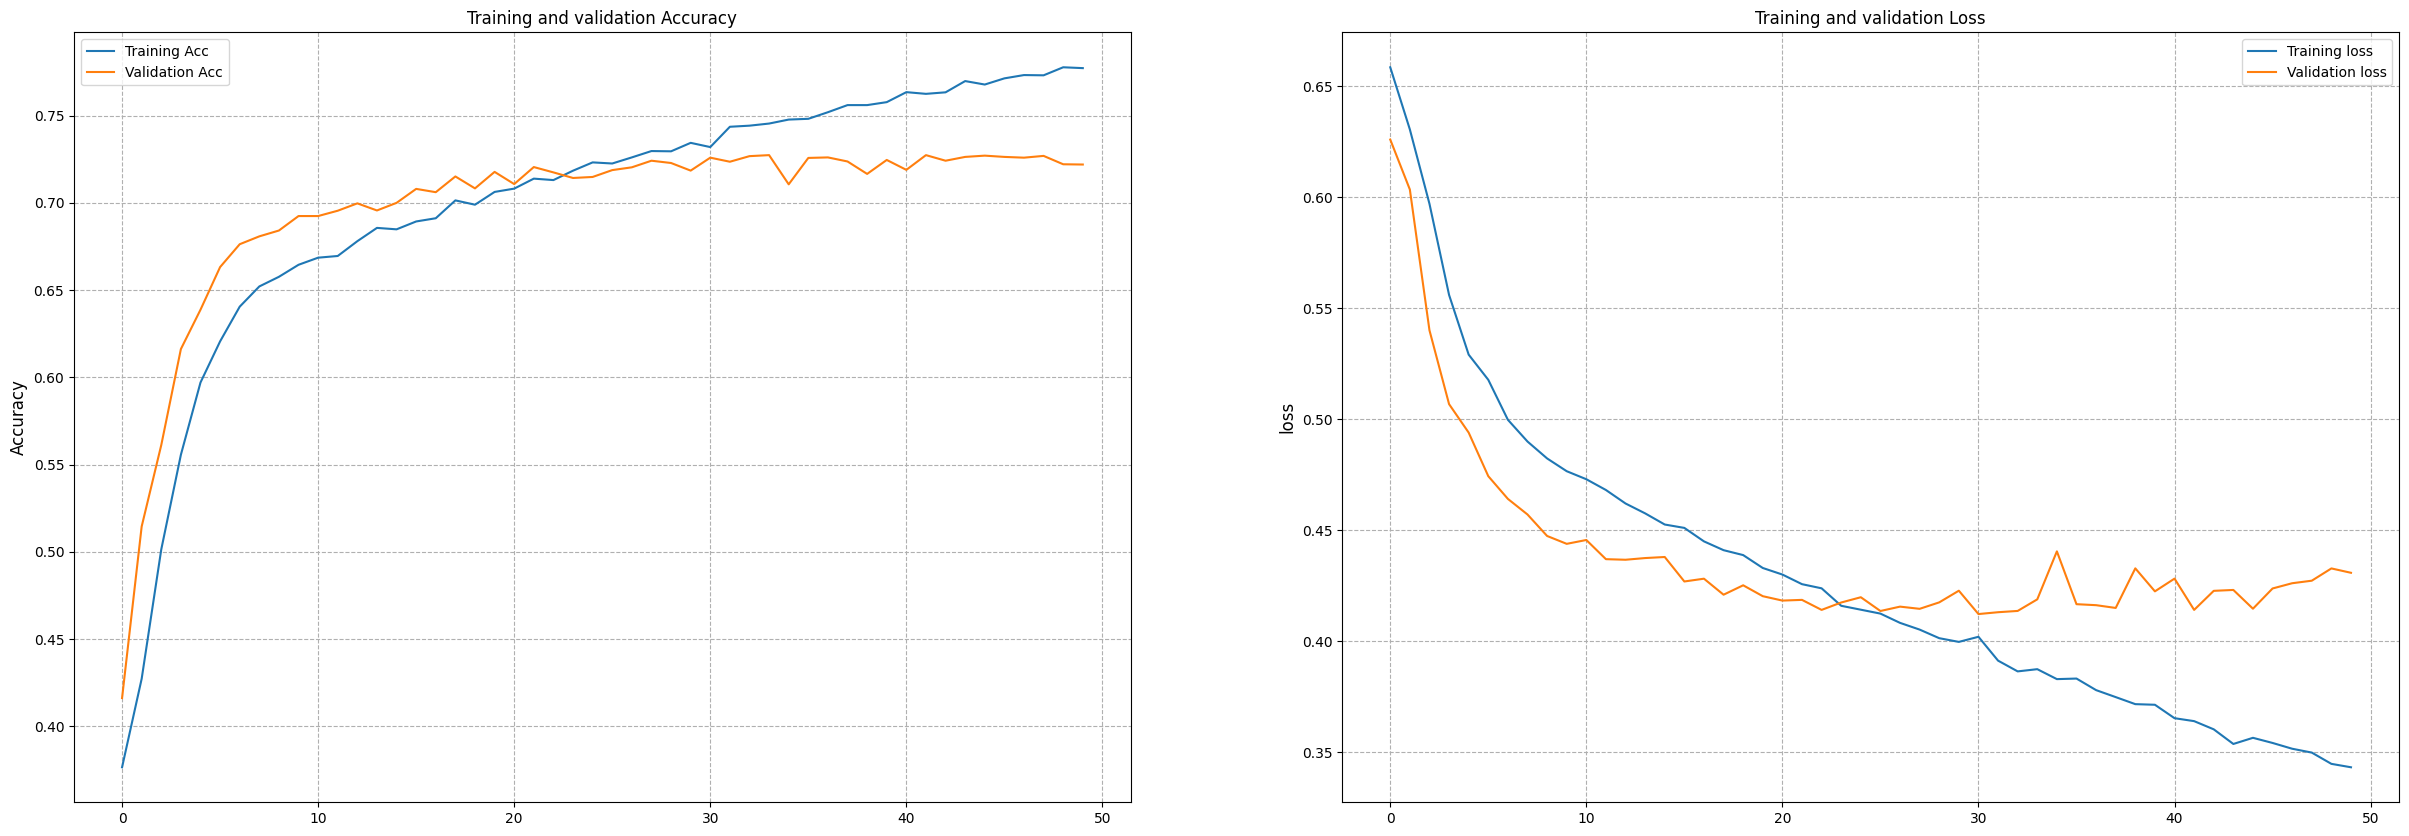

In [40]:
fig,ax= plt.subplots(1,2 , figsize=(30,10))

plt.subplot(1,2,1)
plt.title('Training and validation Accuracy', fontsize=12)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title('Training and validation Loss', fontsize=12)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('loss', fontsize=12)
plt.legend()
plt.grid(linestyle='--')
plt.show()

In [41]:
#print accuracy and loss on train and test
print('Train Accuracy: ', model_func.evaluate(X_train1, y_train)[1])
print('Test Accuracy: ', model_func.evaluate(X_test1, y_test)[1])

645/645 [==============================] - 14s 22ms/step - loss: 0.2766 - accuracy: 0.8260
Train Accuracy:  0.825958251953125
215/215 [==============================] - 5s 21ms/step - loss: 0.4308 - accuracy: 0.7220
Test Accuracy:  0.7220200896263123


In [42]:
scores = model_func.predict(X_test1, verbose = 1, batch_size = 10000)
scores[:2]

1/1 [==============================] - 0s 487ms/step


array([[0.9801856 , 0.01815056, 0.00166384],
       [0.07177974, 0.13407081, 0.7941494 ]], dtype=float32)

In [43]:
binary_predictions = np.where(scores == np.max(scores, axis=1, keepdims=True), 1, 0)
binary_predictions

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

In [44]:
def conmat_dec(y_test, binary_predictions):
    # Convert one-hot encoded predictions to class labels
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(binary_predictions, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and axis for the confusion matrix plot
    fig, ax = plt.subplots()

    # Plot the confusion matrix as a heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Customize the plot
    ax.figure.colorbar(im, ax=ax)
    classes = ['Positive', 'Negative', 'Neutral']  # Specify the class labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           xlabel='Predicted label', ylabel='True label',
           title='Confusion Matrix')
    plt.xticks(rotation=45)

    # Add text annotations to each cell
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Display the plot
    plt.tight_layout()
    plt.show()

    report = classification_report(y_true, y_pred)

    # Print the classification report
    print("Classification Report:")
    print(report)

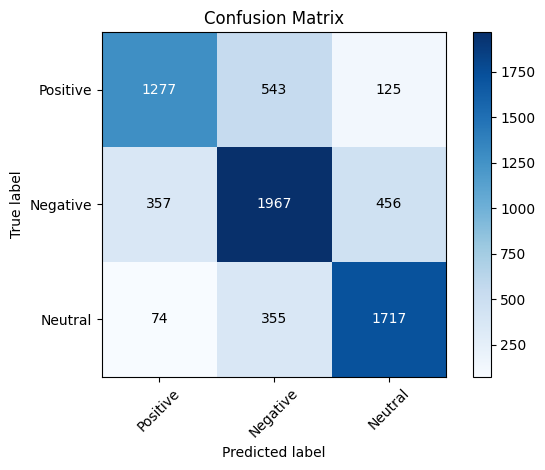

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1945
           1       0.69      0.71      0.70      2780
           2       0.75      0.80      0.77      2146

    accuracy                           0.72      6871
   macro avg       0.73      0.72      0.72      6871
weighted avg       0.72      0.72      0.72      6871



In [45]:
conmat_dec(y_test, binary_predictions)

terlihat pada confusion matrix dan classification report diatas mengalami impovement walaupun tidak membuat model menjadi sangat baik.

Pada Classification Report dapat dilihat nilai accuracy naik dari 62% menjadi 72%.

# Kesimpulan

Model setelah dilakukan dituning, mengalami peningkatan performa.

Model melakukan prediksi dengan lebih cepat dan nilai accuracy meningkat.

Model ini menurut saya masih belum terlalu bagus dalam memprediksi. Karena hanya memiliki nilai accuracy sebesar 72%.

Saran pengembangan:
1. Bisa menggunakan teknik embeding lain seperti word2vec, ELMo, FastText, dll.
2. Melakukan balancing target
3. Menggunakan layer lain selain LSTM, contohnya GRU.
4. Melakukan uji coba penambahan atau pengurangan layer serta neuron didalamnya.
5. Menggunakan dataset lain untuk proses training.

Saran diatas dapat dilakukan untuk meningkatkan performa model.

# Prediction on X Twitter(Scraping)

In [46]:
x_data = pd.read_csv('/content/gdrive/MyDrive/Data Science/Dataset/x_sentiment.csv', delimiter = ';').drop(['created_at', 'id_str', 'quote_count', 'reply_count', 'retweet_count',	'favorite_count',	'lang',	'user_id_str',	'conversation_id_str',	'username',	'tweet_url'], axis=1)
x_data

,full_text
0,Seems like @X is now faster than twitter? What...
1,Did Twitter actually turn itself into x lol
2,"@shainenm Haha same here, i saw the X and unin..."
3,Now my Twitter has turned into X
4,@StopAntisemites It’s jarring how obsessed Jew...
...,...
3473,My Twitter app finally switched over to X and ...
3474,Goodmorning! I couldn’t find my Twitter App t...
3475,So instead of “Twitter Crush” it’ll be “X Crus...
3476,"Ye, formerly known as Kanye West, restored to ..."


In [47]:
x_data['full_text'] = x_data['full_text'].apply(lambda x: text_proses(x))
x_data

,full_text
0,seem like faster twitter 's experience
1,twitter actually turn x lol
2,haha saw x uninstalled know bagong twitter log...
3,twitter turn x
4,jar obsess jewish twitter x users silence ever...
...,...
3473,twitter app finally switch x twitter notificat...
3474,goodmorning find twitter app today
3475,instead twitter crush x crush want x crush lol
3476,ye formerly know kanye west restore x formerly...


In [48]:
x_data_val = pad_sequences(tokenizer.texts_to_sequences(x_data.full_text), maxlen = 30)

print("X Validation Shape:",x_data_val.shape)

X Validation Shape: (3478, 30)


In [49]:
x_scores = model_func.predict(x_data_val, verbose = 1, batch_size = 10000)
x_scores[:2]

1/1 [==============================] - 0s 40ms/step


array([[0.46440068, 0.3187262 , 0.2168731 ],
       [0.07517025, 0.7647477 , 0.16008212]], dtype=float32)

In [50]:
df = pd.DataFrame(x_scores, columns=['Positive', 'Negative', 'Neutral'])
new_df = pd.DataFrame(np.where(x_scores == np.max(x_scores, axis=1, keepdims=True), True, False), columns=['Positive_class', 'Negative_class', 'Neutral_class'])
# Append new DataFrame to the existing DataFrame (df)
df = pd.concat([df, new_df], axis=1)
condf = pd.concat([x_data, df], axis=1)
condf.head()

,full_text,Positive,Negative,Neutral,Positive_class,Negative_class,Neutral_class
0,seem like faster twitter 's experience,0.464401,0.318726,0.216873,True,False,False
1,twitter actually turn x lol,0.075170,0.764748,0.160082,False,True,False
2,haha saw x uninstalled know bagong twitter log...,0.000271,0.999408,0.000321,False,True,False
3,twitter turn x,0.326527,0.581936,0.091537,False,True,False
4,jar obsess jewish twitter x users silence ever...,0.035353,0.947920,0.016727,False,True,False


Dari data di atas dapat dilihat probabilitas tweet yang diprediksi. Sebuah tweet yang memiliki nilai probabilitas sentiment paling besar, maka akan menjadi label dari sentimentnya.

In [51]:
# Buat kolom baru 'Sentiment' berdasarkan nilai maksimum dari setiap baris
condf['Sentiment'] = condf[['Positive_class', 'Negative_class', 'Neutral_class']].idxmax(axis=1)
condf['Sentiment'] = condf['Sentiment'].str.replace('_class', '')  # Hapus '_class' dari nama kategori

In [52]:
condf

,full_text,Positive,Negative,Neutral,Positive_class,Negative_class,Neutral_class,Sentiment
0,seem like faster twitter 's experience,0.464401,0.318726,0.216873,True,False,False,Positive
1,twitter actually turn x lol,0.075170,0.764748,0.160082,False,True,False,Negative
2,haha saw x uninstalled know bagong twitter log...,0.000271,0.999408,0.000321,False,True,False,Negative
3,twitter turn x,0.326527,0.581936,0.091537,False,True,False,Negative
4,jar obsess jewish twitter x users silence ever...,0.035353,0.947920,0.016727,False,True,False,Negative
...,...,...,...,...,...,...,...,...
3473,twitter app finally switch x twitter notificat...,0.068636,0.907685,0.023679,False,True,False,Negative
3474,goodmorning find twitter app today,0.001559,0.997679,0.000762,False,True,False,Negative
3475,instead twitter crush x crush want x crush lol,0.052036,0.420674,0.527290,False,False,True,Neutral
3476,ye formerly know kanye west restore x formerly...,0.020588,0.077546,0.901867,False,False,True,Neutral


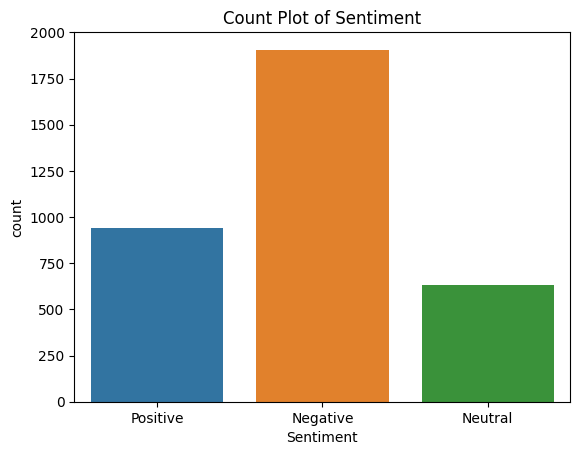

In [53]:
sns.countplot(x='Sentiment', data=condf)
plt.title('Count Plot of Sentiment')
plt.show()

Dari hasil scraping jika kita gunakan model ini untuk menentukan sentimennya, didapatkan sentiment paling banyak yaitu negatif.

Sehingga dapat disimpulkan perubahan nama dari Twitter menjadi X, mayoritas pengguna twitter tidak menyukainya.

# Save Model

In [54]:
model_func.save('sentiment.h5')

# Test model

In [68]:
# load model
load_model_func = load_model('sentiment.h5')

In [69]:
text = "app look shitty x change back twitter"
data = {
    'text': [text],
}
df_x = pd.DataFrame(data)

In [70]:
x_data_val = pad_sequences(tokenizer.texts_to_sequences(df_x.text), maxlen = 30)


In [73]:
x_scores1

array([[0.0032106 , 0.9934197 , 0.00336971]], dtype=float32)

In [72]:
x_scores1 = load_model_func.predict(x_data_val, verbose = 1, batch_size = 10000)
x_scores1[:2]


1/1 [==============================] - 0s 489ms/step


array([[0.0032106 , 0.9934197 , 0.00336971]], dtype=float32)

In [74]:
df2 = pd.DataFrame(x_scores1, columns=['Positive', 'Negative', 'Neutral'])

In [76]:
df2 = pd.DataFrame(x_scores1, columns=['Positive', 'Negative', 'Neutral'])
new_df2 = pd.DataFrame(np.where(x_scores1 == np.max(x_scores1, axis=1, keepdims=True), True, False), columns=['Positive_class', 'Negative_class', 'Neutral_class'])
df2 = pd.concat([df2, new_df2], axis=1)
condf2 = pd.concat([df_x, df2], axis=1)
condf2.head()

,text,Positive,Negative,Neutral,Positive_class,Negative_class,Neutral_class
0,app look shitty x change back twitter,0.003211,0.99342,0.00337,False,True,False


In [77]:
condf2['Sentiment'] = condf2[['Positive_class', 'Negative_class', 'Neutral_class']].idxmax(axis=1)
condf2['Sentiment'] = condf2['Sentiment'].str.replace('_class', '')  # Hapus '_class' dari nama kategori

In [78]:
condf2.Sentiment[0]

'Negative'